In [137]:
import time
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
import numpy as np
from numpy import sort

In [154]:
# 读取差值数据集
dataset_path = '/Users/xiafei/Downloads/itu-dataset/diff_dataset.csv'
testset_path = '/Users/xiafei/Downloads/itu-dataset/diff_testset.csv'

In [155]:
# train
dataset = pd.read_csv(dataset_path)
testset = pd.read_csv(testset_path)

In [156]:
# 删除奇怪的字段
dataset.drop(columns=['Unnamed: 0'], inplace=True)
testset.drop(columns=['Unnamed: 0'], inplace=True)

In [157]:
# 删除修复状态
data_drop_index = dataset[dataset['v_type_code'] %2 == 0].index.tolist()
dataset.drop(index=data_drop_index, axis=0, inplace=True)
test_drop_index = testset[testset['v_type_code'] %2 == 0].index.tolist()
testset.drop(index=test_drop_index, axis=0, inplace=True)

print('dataset:')
print(dataset.shape)
print('testset:')
print(testset.shape)

column = dataset.columns

dataset:
(930, 997)
testset:
(840, 997)


# 正则化

In [158]:
# X_train = dataset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)
# X_test = testset[column[:-1]].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.max(x) - np.min(x) != 0 else 0)

# 去掉空值等

In [159]:
# dataset.dropna(axis=1, how='any', inplace=True)
# testset.dropna(axis=1, how='any', inplace=True)
# print('dataset:')
# print(dataset.shape)
# print('testset:')
# print(testset.shape)

# 划分训练测试

In [160]:
X_train = dataset[column[:-1]]
X_test = testset[column[:-1]]
y_train = dataset[column[-1]]
y_test = testset[column[-1]]

X = pd.concat([X_train, X_test], axis=0, ignore_index=True, sort=False)
Y = pd.concat([y_train, y_test], axis=0, ignore_index=True, sort=False)
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X.shape, Y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

ss = StandardScaler()
std_X_train = ss.fit_transform(X_train)
std_X_test = ss.fit_transform(X_test)

(1770, 996) (1770,)
(930, 996) (930,)
(840, 996) (840,)


In [161]:
# XGBoost
def xgboost(X_train, y_train, X_test, y_test):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=300, objective='multi:softmax', num_class=12, random_state=0)
    xgb.fit(X_train, y_train)
    middle_time = time.time()
    y_pred = xgb.predict(X_test)
    current_time = time.time()
    accuracy_score(y_test, y_pred)

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix xgb:')
    print(cm)
    print('classification report xgb:')
    print(classification_report(y_test, y_pred))
    # ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
    plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                          normalize=True, title='Normalized confusion matrix')

    plt.show()

In [170]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
        # color="red" if cm[i, j] > thresh else "black")
    # plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [163]:
model = XGBClassifier(importance_type='gain', n_estimators=300)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

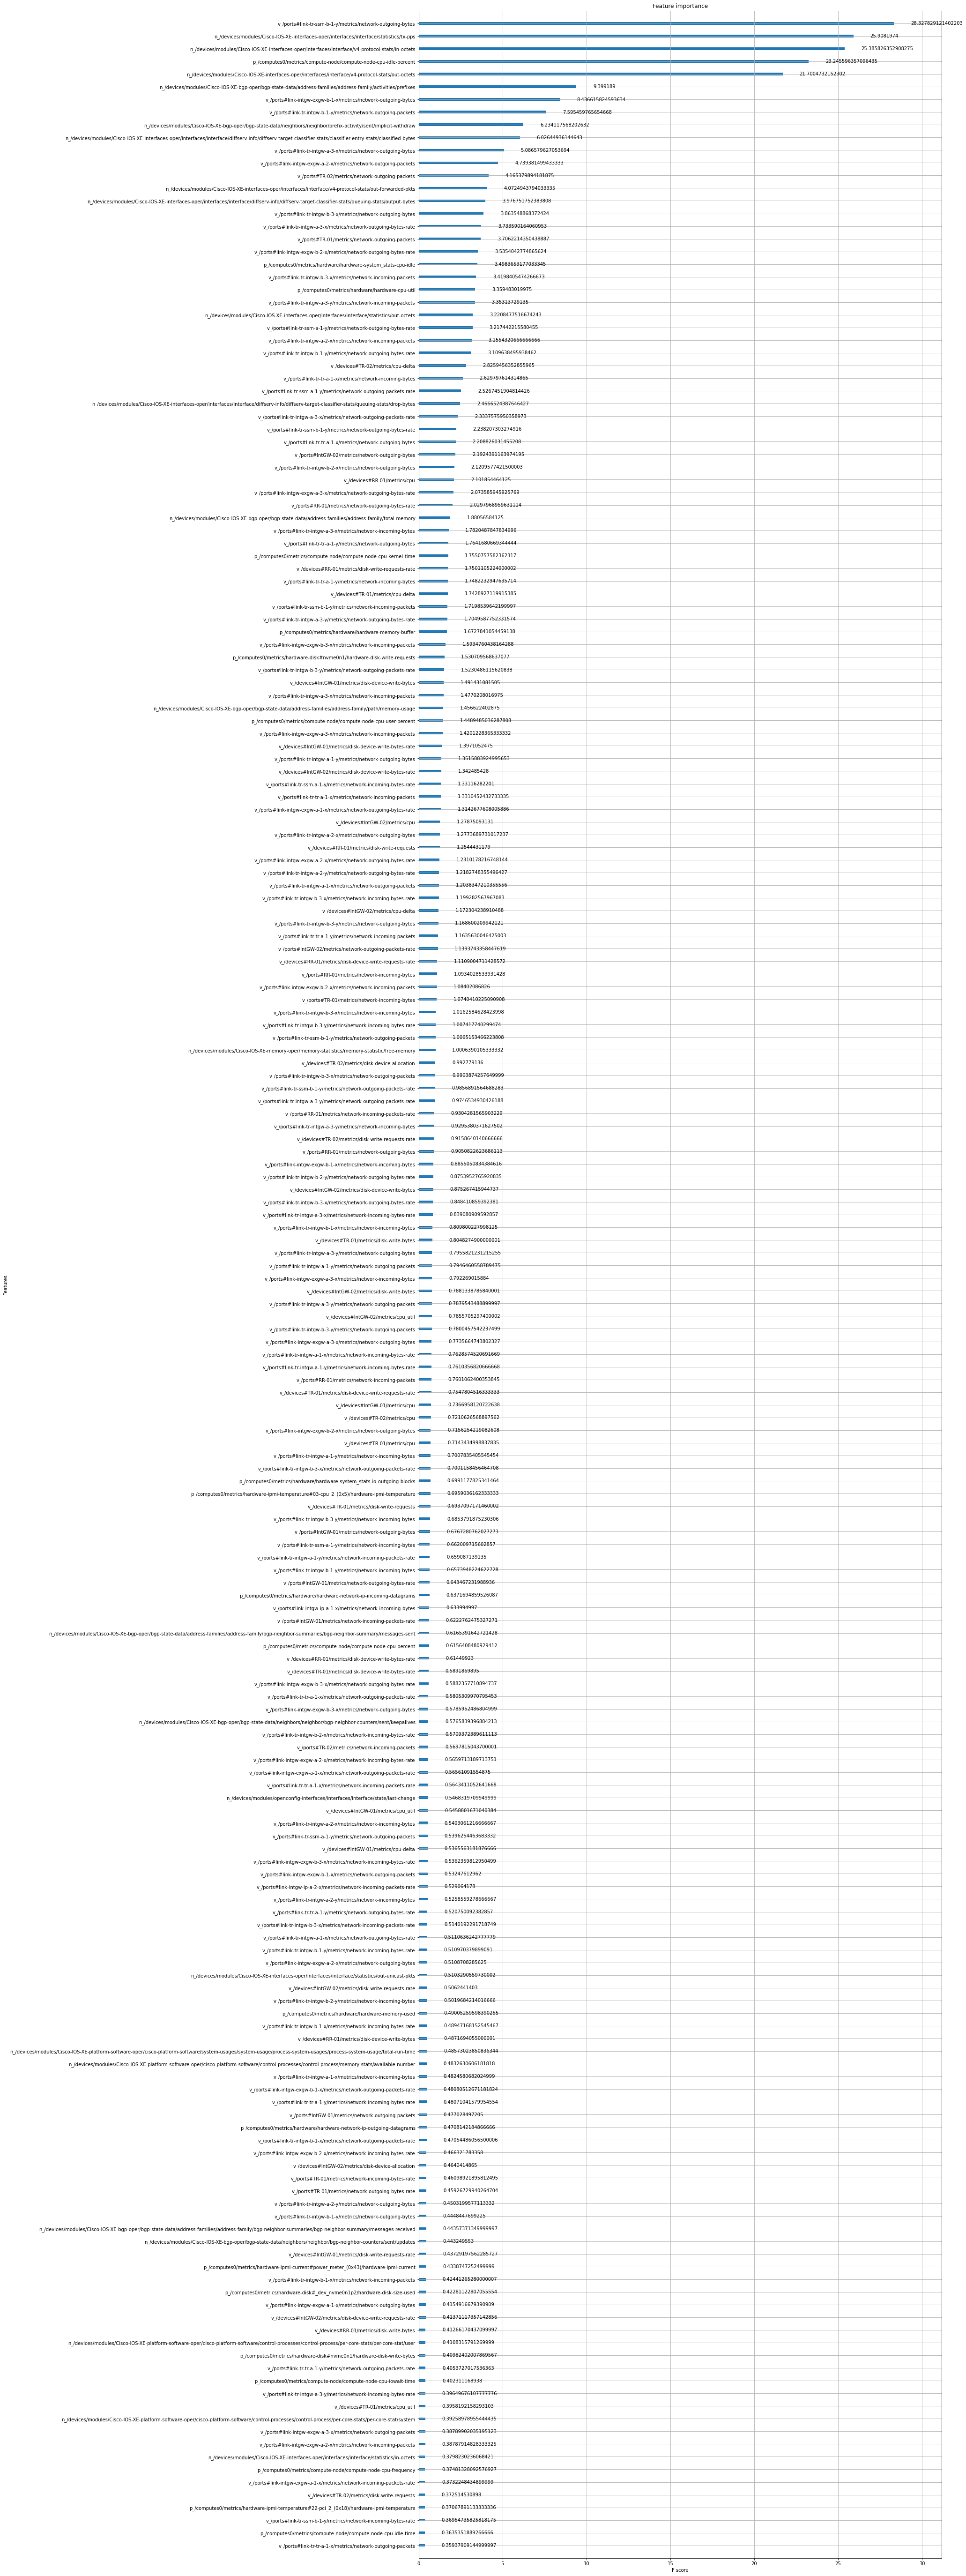

In [164]:
_, ax = plt.subplots(figsize=(20, 100))
plot_importance(model, ax=ax, max_num_features=200, importance_type='gain')
plt.show()

In [165]:
thresholds = sort(model.feature_importances_)[-200:]
print(thresholds)

[0.00087747 0.00088762 0.0009023  0.00090506 0.00090954 0.00091128
 0.00091515 0.00092739 0.00094706 0.0009471  0.00095856 0.00096644
 0.0009681  0.00098229 0.00098977 0.00100064 0.0010031  0.00100757
 0.00101013 0.00101447 0.00103235 0.00103626 0.00105936 0.0010677
 0.00108225 0.00108304 0.00108614 0.00109951 0.00112136 0.00112556
 0.00113302 0.00113858 0.00114889 0.00114955 0.00116472 0.00117371
 0.00117395 0.00117798 0.00117995 0.00118597 0.00118949 0.00119511
 0.00119652 0.00122562 0.00123606 0.00124603 0.00124736 0.0012476
 0.00124783 0.00125504 0.00127148 0.00128394 0.00129178 0.00130011
 0.00130929 0.00131007 0.00131756 0.00131923 0.00133283 0.00133516
 0.00137791 0.00138101 0.00138189 0.00139119 0.00139401 0.0014078
 0.00141271 0.00141744 0.00143625 0.00143857 0.00150038 0.00150316
 0.00150536 0.00151937 0.00154798 0.00155573 0.00157111 0.00160511
 0.00160924 0.00161638 0.00165232 0.00167344 0.00169378 0.00169914
 0.00170698 0.00170942 0.00171105 0.00174416 0.00174729 0.0017605

In [166]:
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.4f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

Thresh=0.0009, n=200, Accuracy: 76.55%
Thresh=0.0009, n=199, Accuracy: 77.38%
Thresh=0.0009, n=198, Accuracy: 75.24%
Thresh=0.0009, n=197, Accuracy: 75.60%
Thresh=0.0009, n=196, Accuracy: 76.07%
Thresh=0.0009, n=195, Accuracy: 76.90%
Thresh=0.0009, n=194, Accuracy: 76.90%
Thresh=0.0009, n=193, Accuracy: 76.19%
Thresh=0.0009, n=192, Accuracy: 75.95%
Thresh=0.0009, n=191, Accuracy: 75.95%
Thresh=0.0010, n=190, Accuracy: 76.55%
Thresh=0.0010, n=189, Accuracy: 76.90%
Thresh=0.0010, n=188, Accuracy: 76.07%
Thresh=0.0010, n=187, Accuracy: 76.19%
Thresh=0.0010, n=186, Accuracy: 76.31%
Thresh=0.0010, n=185, Accuracy: 75.95%
Thresh=0.0010, n=184, Accuracy: 75.48%
Thresh=0.0010, n=183, Accuracy: 75.71%
Thresh=0.0010, n=182, Accuracy: 76.07%
Thresh=0.0010, n=181, Accuracy: 76.55%
Thresh=0.0010, n=180, Accuracy: 75.95%
Thresh=0.0010, n=179, Accuracy: 77.02%
Thresh=0.0011, n=178, Accuracy: 76.31%
Thresh=0.0011, n=177, Accuracy: 76.67%
Thresh=0.0011, n=176, Accuracy: 76.79%
Thresh=0.0011, n=175, Acc

In [173]:
def decision_tree(X_train, y_train, X_test, y_test):
    last_time = time.time()
    dt = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)

    dt.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = dt.predict(X_test)

    current_time = time.time()

    accuracy_score(y_test, y_pred)

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))

    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix dt:')
    print(cm)
    print('classification report dt:')
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                          normalize=True, title='Normalized confusion matrix')

    plt.show()

In [174]:
# random forest
def random_forest(X_train, y_train, X_test, y_test):
    last_time = time.time()
    rf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0)

    rf.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = rf.predict(X_test)

    current_time = time.time()

    accuracy_score(y_test, y_pred)

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix rf:')
    print(cm)
    print('classification report rf:')
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                          normalize=True, title='Normalized confusion matrix')

    plt.show()

In [202]:
# XGBoost
def xgboost_plt(X_train, y_train, X_test, y_test):
    last_time = time.time()
    xgb = XGBClassifier(n_estimators=300, n_jobs=-1, objective='multi:softmax', num_class=6, random_state=0)

    xgb.fit(X_train, y_train)
    middle_time = time.time()

    y_pred = xgb.predict(X_test)

    current_time = time.time()

    accuracy_score(y_test, y_pred)

    print("训练耗时： {}".format(middle_time - last_time))
    print("测试耗时： {}".format(current_time - middle_time))
    cm = confusion_matrix(y_test, y_pred)
    print('confusion matrix xgb:')
    print(cm)
    print('classification report xgb:')
    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(cm, classes=['1', '3', '5', '7', '9', '11'],
                          normalize=True, title='Normalized confusion matrix')

    plt.show()

训练耗时： 0.26156115531921387
测试耗时： 0.014303922653198242
confusion matrix dt:
[[ 37  12   4   7   3   1]
 [  1  33  20  10   1   7]
 [  0  15  96  74   0   4]
 [  0  14  67  86   1  11]
 [  0   3   6   2 145   0]
 [  0   3  21  36   0 120]]
classification report dt:
              precision    recall  f1-score   support

           1       0.97      0.58      0.73        64
           3       0.41      0.46      0.43        72
           5       0.45      0.51      0.48       189
           7       0.40      0.48      0.44       179
           9       0.97      0.93      0.95       156
          11       0.84      0.67      0.74       180

    accuracy                           0.62       840
   macro avg       0.67      0.60      0.63       840
weighted avg       0.66      0.62      0.63       840

Normalized confusion matrix
[[0.578125   0.1875     0.0625     0.109375   0.046875   0.015625  ]
 [0.01388889 0.45833333 0.27777778 0.13888889 0.01388889 0.09722222]
 [0.         0.07936508 0.50

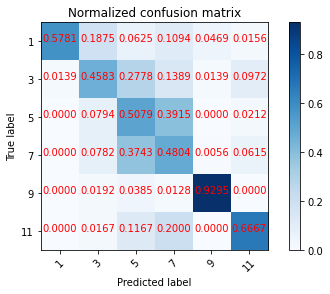

In [176]:
decision_tree(X_train, y_train, X_test, y_test)

训练耗时： 2.173841953277588
测试耗时： 0.06203436851501465
confusion matrix rf:
[[ 56   1   5   2   0   0]
 [  0  38  25   8   1   0]
 [  0   0 127  62   0   0]
 [  0   0  58 120   1   0]
 [  0   0   2   1 153   0]
 [  0   0   8  45   0 127]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      0.88      0.93        64
           3       0.97      0.53      0.68        72
           5       0.56      0.67      0.61       189
           7       0.50      0.67      0.58       179
           9       0.99      0.98      0.98       156
          11       1.00      0.71      0.83       180

    accuracy                           0.74       840
   macro avg       0.84      0.74      0.77       840
weighted avg       0.79      0.74      0.75       840

Normalized confusion matrix
[[0.875      0.015625   0.078125   0.03125    0.         0.        ]
 [0.         0.52777778 0.34722222 0.11111111 0.01388889 0.        ]
 [0.         0.         0.67195

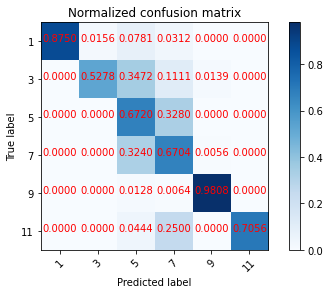

In [177]:
random_forest(X_train, y_train, X_test, y_test)

训练耗时： 38.315030097961426
测试耗时： 0.0679008960723877
confusion matrix xgb:
[[ 60   3   1   0   0   0]
 [  0  47  16   7   2   0]
 [  0   4 141  44   0   0]
 [  0   0  74 104   1   0]
 [  0   0   1   2 153   0]
 [  0   1  29  33   1 116]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        64
           3       0.85      0.65      0.74        72
           5       0.54      0.75      0.63       189
           7       0.55      0.58      0.56       179
           9       0.97      0.98      0.98       156
          11       1.00      0.64      0.78       180

    accuracy                           0.74       840
   macro avg       0.82      0.76      0.78       840
weighted avg       0.78      0.74      0.75       840

Normalized confusion matrix
[[0.9375     0.046875   0.015625   0.         0.         0.        ]
 [0.         0.65277778 0.22222222 0.09722222 0.02777778 0.        ]
 [0.         0.02116402 0.746

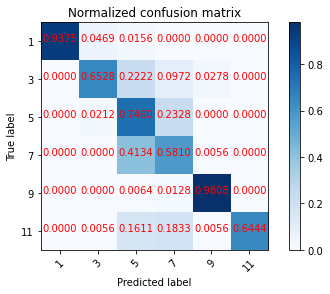

In [178]:
xgboost_plt(X_train, y_train, X_test, y_test)

In [183]:
for c in X_train.columns:
    print(c)

n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/paths
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/memory-usage
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/as
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/bgp-version
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/input-queue
n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-rece

In [194]:
X_train_n = X_train[X_train.columns[:269]]
X_test_n = X_test[X_test.columns[:269]]
X_train_n.head()

,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/paths,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/activities/prefixes,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/memory-usage,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/as-path/total-entries,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/as,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/bgp-version,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/input-queue,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-received,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/messages-sent,n_/devices/modules/Cisco-IOS-XE-bgp-oper/bgp-state-data/address-families/address-family/bgp-neighbor-summaries/bgp-neighbor-summary/output-queue,...,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/last-clear,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-broadcast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-discards,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-errors,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-multicast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-octets,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/counters/out-unicast-pkts,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/ifindex,n_/devices/modules/openconfig-interfaces/interfaces/interface/subinterfaces/subinterface/state/last-change,n_nexthop
1,7821.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3790.0,0.0,...,-121000.0,0.0,0.0,0.0,0.0,11099474.0,17706.0,0.0,-121000.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,7.0,0.0,...,91000.0,0.0,0.0,0.0,0.0,11098164.0,17691.0,0.0,91000.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.0,-14422.0,0.0,...,25000.0,0.0,0.0,0.0,0.0,13873352.0,22104.0,0.0,25000.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,...,869000.0,0.0,0.0,0.0,0.0,11099771.0,17695.0,0.0,999869000.0,0.0
9,8.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,...,30000.0,0.0,0.0,0.0,0.0,11098173.0,17689.0,0.0,30000.0,0.0


In [195]:
X_train_p = X_train[X_train.columns[269:412]]
X_test_p = X_test[X_test.columns[269:412]]
X_train_p.head()

,p_/computes0/cpu_info/topology/cells,p_/computes0/cpu_info/topology/cores,p_/computes0/cpu_info/topology/sockets,p_/computes0/cpu_info/topology/threads,p_/computes0/current_workload,p_/computes0/disk_available_least,p_/computes0/free_disk_gb,p_/computes0/free_ram_mb,p_/computes0/hypervisor_version,p_/computes0/id,...,p_/computes0/metrics/hardware/hardware-network-ip-incoming-datagrams,p_/computes0/metrics/hardware/hardware-network-ip-outgoing-datagrams,p_/computes0/metrics/hardware/hardware-system_stats-cpu-idle,p_/computes0/metrics/hardware/hardware-system_stats-io-incoming-blocks,p_/computes0/metrics/hardware/hardware-system_stats-io-outgoing-blocks,p_/computes0/running_vms,p_/computes0/service/id,p_/computes0/vcpus,p_/computes0/vcpus_used,p_nexthop
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,781293.0,775898.0,2.0,0.0,536744.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,687736.5,866015.0,6.0,0.0,525832.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1155139.0,1149686.0,5.0,0.0,800488.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,775373.5,769948.0,4.0,0.0,524224.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,782965.0,679605.0,7.5,0.0,549792.0,0.0,0.0,0.0,0.0,0.0


In [196]:
X_train_v = X_train[X_train.columns[412:]]
X_test_v = X_test[X_test.columns[412:]]
X_train_v.head()

,v_/devices#IntGW-01/flavor/disk,v_/devices#IntGW-01/flavor/ram,v_/devices#IntGW-01/flavor/vcpus,v_/devices#IntGW-01/image/metrics/image-size,v_/devices#IntGW-01/image/min_disk,v_/devices#IntGW-01/image/min_ram,v_/devices#IntGW-01/image/size,v_/devices#IntGW-01/metrics/compute-instance-booting-time,v_/devices#IntGW-01/metrics/cpu,v_/devices#IntGW-01/metrics/cpu-delta,...,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-incoming-packets-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-bytes-rate,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-drop,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-error,v_/ports#link-tr-tr-a-1-y/metrics/network-outgoing-packets-rate,v_nexthop
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,-3.272000e+10,...,0.0,0.0,-0.000110,3250.0,4.414233,27.0,0.0,0.0,-0.000637,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.306000e+11,9.670000e+09,...,0.0,0.0,0.033176,3302.0,0.849073,29.0,0.0,0.0,-0.000719,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.561100e+11,-3.900000e+08,...,0.0,0.0,0.000054,3932.0,-0.049194,34.0,0.0,0.0,-0.017112,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.077000e+11,-1.446000e+10,...,0.0,0.0,-0.116318,2884.0,-2.326906,26.0,0.0,0.0,-0.000237,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.238100e+11,-1.755000e+10,...,0.0,0.0,-0.116808,0.0,-12.334812,0.0,0.0,0.0,-0.100105,0.0


训练耗时： 0.04903697967529297
测试耗时： 0.0029697418212890625
confusion matrix dt:
[[ 39   8   7   3   3   4]
 [  2  37  16  13   1   3]
 [  1  22 105  50   0  11]
 [  5  19  85  58   1  11]
 [  0   1   1   2 152   0]
 [  5  13  27  37   0  98]]
classification report dt:
              precision    recall  f1-score   support

           1       0.75      0.61      0.67        64
           3       0.37      0.51      0.43        72
           5       0.44      0.56      0.49       189
           7       0.36      0.32      0.34       179
           9       0.97      0.97      0.97       156
          11       0.77      0.54      0.64       180

    accuracy                           0.58       840
   macro avg       0.61      0.59      0.59       840
weighted avg       0.61      0.58      0.59       840

Normalized confusion matrix
[[0.609375   0.125      0.109375   0.046875   0.046875   0.0625    ]
 [0.02777778 0.51388889 0.22222222 0.18055556 0.01388889 0.04166667]
 [0.00529101 0.11640212 0.5

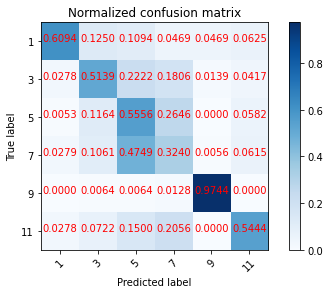

In [197]:
decision_tree(X_train_n, y_train, X_test_n, y_test)

训练耗时： 0.03504586219787598
测试耗时： 0.003673076629638672
confusion matrix dt:
[[51  9  0  2  0  2]
 [ 1 17 20 20  7  7]
 [ 0 34 89 51 12  3]
 [ 0 28 78 56 14  3]
 [ 0  8 74 45 24  5]
 [ 1 11 47 26  9 86]]
classification report dt:
              precision    recall  f1-score   support

           1       0.96      0.80      0.87        64
           3       0.16      0.24      0.19        72
           5       0.29      0.47      0.36       189
           7       0.28      0.31      0.30       179
           9       0.36      0.15      0.22       156
          11       0.81      0.48      0.60       180

    accuracy                           0.38       840
   macro avg       0.48      0.41      0.42       840
weighted avg       0.45      0.38      0.40       840

Normalized confusion matrix
[[0.796875   0.140625   0.         0.03125    0.         0.03125   ]
 [0.01388889 0.23611111 0.27777778 0.27777778 0.09722222 0.09722222]
 [0.         0.17989418 0.47089947 0.26984127 0.06349206 0.01587

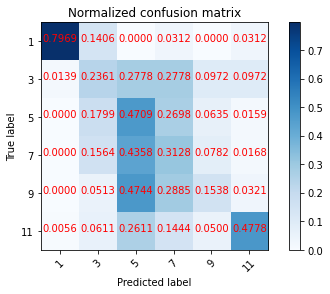

In [198]:
decision_tree(X_train_p, y_train, X_test_p, y_test)

训练耗时： 0.2465038299560547
测试耗时： 0.008208990097045898
confusion matrix dt:
[[ 37   1  11  11   1   3]
 [  1  30  19  19   3   0]
 [  2   7  72  97   4   7]
 [  1   4  73  89   7   5]
 [  2   5  31  10 104   4]
 [  3   1  19  22   4 131]]
classification report dt:
              precision    recall  f1-score   support

           1       0.80      0.58      0.67        64
           3       0.62      0.42      0.50        72
           5       0.32      0.38      0.35       189
           7       0.36      0.50      0.42       179
           9       0.85      0.67      0.75       156
          11       0.87      0.73      0.79       180

    accuracy                           0.55       840
   macro avg       0.64      0.54      0.58       840
weighted avg       0.61      0.55      0.57       840

Normalized confusion matrix
[[0.578125   0.015625   0.171875   0.171875   0.015625   0.046875  ]
 [0.01388889 0.41666667 0.26388889 0.26388889 0.04166667 0.        ]
 [0.01058201 0.03703704 0.380

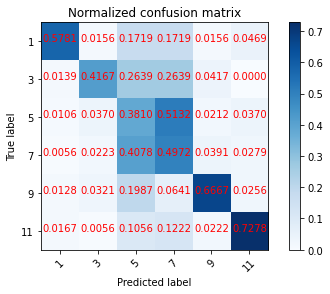

In [199]:
decision_tree(X_train_v, y_train, X_test_v, y_test)

训练耗时： 0.9450688362121582
测试耗时： 0.05806994438171387
confusion matrix rf:
[[ 47  11   3   2   0   1]
 [  0  34  11  26   1   0]
 [  0   0 111  77   1   0]
 [  0   0  69 109   1   0]
 [  0   0   1   0 155   0]
 [  2  13  23  60   0  82]]
classification report rf:
              precision    recall  f1-score   support

           1       0.96      0.73      0.83        64
           3       0.59      0.47      0.52        72
           5       0.51      0.59      0.55       189
           7       0.40      0.61      0.48       179
           9       0.98      0.99      0.99       156
          11       0.99      0.46      0.62       180

    accuracy                           0.64       840
   macro avg       0.74      0.64      0.67       840
weighted avg       0.72      0.64      0.65       840

Normalized confusion matrix
[[0.734375   0.171875   0.046875   0.03125    0.         0.015625  ]
 [0.         0.47222222 0.15277778 0.36111111 0.01388889 0.        ]
 [0.         0.         0.5873

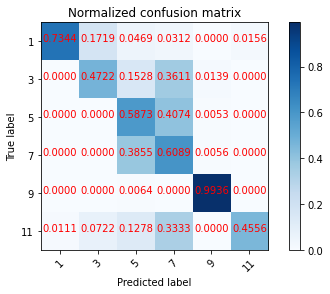

训练耗时： 0.8702070713043213
测试耗时： 0.07609009742736816
confusion matrix rf:
[[ 58   1   0   3   0   2]
 [  1   9  40  20   0   2]
 [  0   5 140  44   0   0]
 [  0   2  89  88   0   0]
 [  0   0  89  66   1   0]
 [  1   3  53  37   0  86]]
classification report rf:
              precision    recall  f1-score   support

           1       0.97      0.91      0.94        64
           3       0.45      0.12      0.20        72
           5       0.34      0.74      0.47       189
           7       0.34      0.49      0.40       179
           9       1.00      0.01      0.01       156
          11       0.96      0.48      0.64       180

    accuracy                           0.45       840
   macro avg       0.68      0.46      0.44       840
weighted avg       0.65      0.45      0.42       840

Normalized confusion matrix
[[0.90625    0.015625   0.         0.046875   0.         0.03125   ]
 [0.01388889 0.125      0.55555556 0.27777778 0.         0.02777778]
 [0.         0.02645503 0.7407

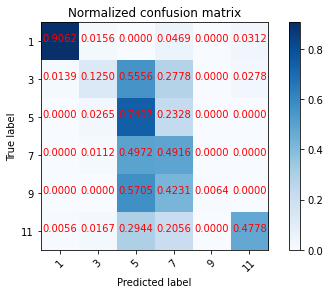

训练耗时： 2.186415910720825
测试耗时： 0.0581059455871582
confusion matrix rf:
[[ 63   0   1   0   0   0]
 [  0  46  16   7   3   0]
 [  0   0 122  67   0   0]
 [  0   0  58 121   0   0]
 [  0   0  13  21 122   0]
 [  0   0  12  40   1 127]]
classification report rf:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        64
           3       1.00      0.64      0.78        72
           5       0.55      0.65      0.59       189
           7       0.47      0.68      0.56       179
           9       0.97      0.78      0.87       156
          11       1.00      0.71      0.83       180

    accuracy                           0.72       840
   macro avg       0.83      0.74      0.77       840
weighted avg       0.78      0.72      0.73       840

Normalized confusion matrix
[[0.984375   0.         0.015625   0.         0.         0.        ]
 [0.         0.63888889 0.22222222 0.09722222 0.04166667 0.        ]
 [0.         0.         0.645502

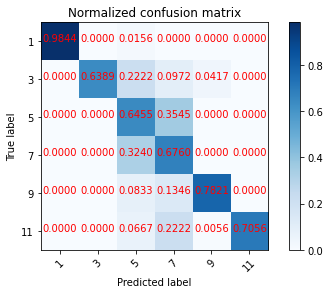

In [200]:
random_forest(X_train_n, y_train, X_test_n, y_test)
random_forest(X_train_p, y_train, X_test_p, y_test)
random_forest(X_train_v, y_train, X_test_v, y_test)

训练耗时： 13.15418815612793
测试耗时： 0.057045936584472656
confusion matrix xgb:
[[ 50   4   3   4   3   0]
 [  0  37  21  12   1   1]
 [  0   7 131  49   0   2]
 [  0   5  96  75   1   2]
 [  0   0   2   0 154   0]
 [  2   7  38  32   0 101]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.96      0.78      0.86        64
           3       0.62      0.51      0.56        72
           5       0.45      0.69      0.55       189
           7       0.44      0.42      0.43       179
           9       0.97      0.99      0.98       156
          11       0.95      0.56      0.71       180

    accuracy                           0.65       840
   macro avg       0.73      0.66      0.68       840
weighted avg       0.70      0.65      0.66       840

Normalized confusion matrix
[[0.78125    0.0625     0.046875   0.0625     0.046875   0.        ]
 [0.         0.51388889 0.29166667 0.16666667 0.01388889 0.01388889]
 [0.         0.03703704 0.69

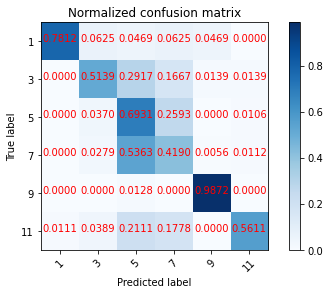

训练耗时： 7.672118902206421
测试耗时： 0.057602882385253906
confusion matrix xgb:
[[ 57   2   2   1   0   2]
 [  1  25  33  11   1   1]
 [  0  17 138  30   4   0]
 [  0  13  87  66  11   2]
 [  0   5 103  35  13   0]
 [  1  11  51  24   4  89]]
classification report xgb:
              precision    recall  f1-score   support

           1       0.97      0.89      0.93        64
           3       0.34      0.35      0.34        72
           5       0.33      0.73      0.46       189
           7       0.40      0.37      0.38       179
           9       0.39      0.08      0.14       156
          11       0.95      0.49      0.65       180

    accuracy                           0.46       840
   macro avg       0.56      0.49      0.48       840
weighted avg       0.54      0.46      0.45       840

Normalized confusion matrix
[[0.890625   0.03125    0.03125    0.015625   0.         0.03125   ]
 [0.01388889 0.34722222 0.45833333 0.15277778 0.01388889 0.01388889]
 [0.         0.08994709 0.73

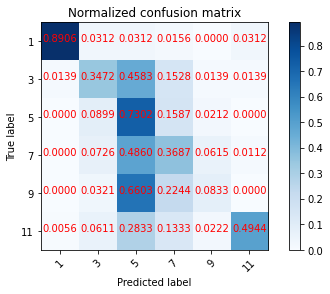

训练耗时： 25.790827989578247
测试耗时： 0.06962108612060547
confusion matrix xgb:
[[ 60   3   1   0   0   0]
 [  0  47  13   6   6   0]
 [  0   2 124  61   2   0]
 [  0   0  51 127   1   0]
 [  0   0   3  11 142   0]
 [  0   3  16  44   1 116]]
classification report xgb:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        64
           3       0.85      0.65      0.74        72
           5       0.60      0.66      0.62       189
           7       0.51      0.71      0.59       179
           9       0.93      0.91      0.92       156
          11       1.00      0.64      0.78       180

    accuracy                           0.73       840
   macro avg       0.82      0.75      0.77       840
weighted avg       0.78      0.73      0.74       840

Normalized confusion matrix
[[0.9375     0.046875   0.015625   0.         0.         0.        ]
 [0.         0.65277778 0.18055556 0.08333333 0.08333333 0.        ]
 [0.         0.01058201 0.65

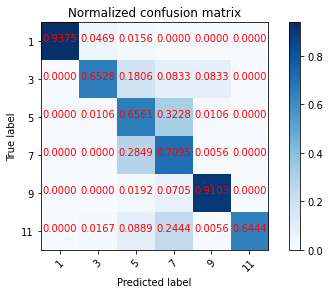

In [203]:
xgboost_plt(X_train_n, y_train, X_test_n, y_test)
xgboost_plt(X_train_p, y_train, X_test_p, y_test)
xgboost_plt(X_train_v, y_train, X_test_v, y_test)